In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

NAMES = ['wb97x', 
         'ani2x_mm', 'ani2x_emle_static', 'ani2x_emle_total', 
         'delta_mm', 'delta_emle_static', 'delta_emle_total',]

In [2]:
def get_shift(x, y, z):
    x0, y0 = -82.5, -12.5 # Position of global minimum
    xy = np.array([x, y]).T
    diff = np.abs(xy - np.array([x0, y0]))
    sum_diff = np.sum(diff, axis=1)
    idx = np.argmin(sum_diff) # idx of global minimum
    return z[idx]

def read_pmf(filename):
    return np.loadtxt(filename).T[:3]

def shift_pmf(pmf):
    x, y, z = pmf
    return np.array([x, y, z - get_shift(x, y, z)])

def get_rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

In [3]:
full_data = {name: shift_pmf(read_pmf(f'data/{name}.PMF')) for name in NAMES}
mask = np.mean(np.array([v[2,:] for v in full_data.values()]), axis=0) < 1000
masked_data = {k: v[:,mask] for k, v in full_data.items()}

In [4]:
pmf_data = {k: v.reshape(3, 72, 72) for k, v in full_data.items()}

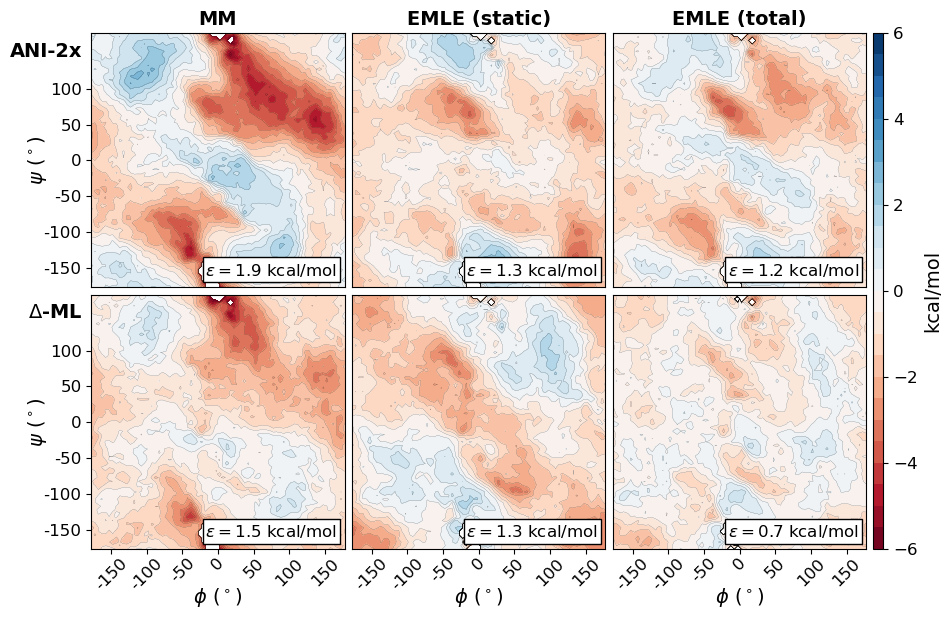

In [5]:
plot_names = NAMES[1:]
x_names = ['MM', 'EMLE (static)', 'EMLE (total)']
y_names = ['ANI-2x', '$\Delta$-ML']

x, y = pmf_data['wb97x'][:2]

levels = np.linspace(-6, 6, 25)
x_ticks = np.arange(-150, 160, 50)
y_ticks = np.arange(-150, 150, 50)

plt.rc('figure', facecolor='w')
plt.rc('font', size=12)

fig, axes = plt.subplots(2, 3, figsize=(10, 6.7))
fig.subplots_adjust(wspace=0.03, hspace=0.03)

for idx, (name) in enumerate(plot_names):
    
    i = idx // 3
    j = idx % 3
    ax = axes[i][j]
    
    z = pmf_data[name][2] - pmf_data['wb97x'][2]
    
    a, b = masked_data[name][2], masked_data['wb97x'][2]
    err = get_rmse(a, b)
    
    if i == 0:
        ax.set_title(x_names[j], fontsize=14, pad=6, weight='semibold')
        ax.set_xticks([])
    else:
        ax.set_xticks(x_ticks, x_ticks, rotation=45)
        ax.xaxis.set_tick_params(pad=1)
        ax.set_xlabel("$\phi$ ($^\circ$)", fontsize=14, labelpad=-5)
        
    if j == 0:
        ax.text(-190, 145, y_names[i], fontsize=14, 
                rotation=0, ha='right', weight='semibold')
        
    if j > 0:
        ax.set_yticks([])
    else:
        ax.set_yticks(y_ticks, y_ticks)
        ax.set_ylabel("$\psi$ ($^\circ$)", fontsize=14, labelpad=-4)
    
    cp = ax.contourf(x, y, z, cmap='RdBu', levels=levels)
    ax.contour(x, y, z, levels=levels, colors='black', 
               linewidths=0.1, linestyles='solid')
    
    label_frame = patches.Rectangle((-21, -170), 192, 35, facecolor='white', 
                                    edgecolor='black', zorder=2)
    ax.add_patch(label_frame)
    ax.text(167, -161, f'$\epsilon = {err:.1f}$ kcal/mol', 
                fontsize=12, ha='right')

cbar_ax = fig.add_axes([0.907, 0.111, 0.01, 0.770])
cbar = plt.colorbar(cp, cax=cbar_ax, ticks=np.arange(-6, 7, 2))
cbar.set_label("kcal/mol", fontsize=14)

plt.savefig('Fig2.png', dpi=300, bbox_inches='tight')
plt.show()